# 1. Perkenalan

Nama : Maulidya Fauziyyah

Latar belakang:

Program ini dibuat untuk mendeteksi penyakit Diabetic Retinopathy. Input pada program ini berupa gambar, gambar tersebut akan di prediksi dengan deep learning untuk mengetahui hasil dari gambar tersebut terkena Diabetic Retinopathy atau tidak.

# 2. Import Libraries

Import libraries berisi libraries yang akan digunakan

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input, GlobalAveragePooling2D, concatenate
from tensorflow.keras.applications import Xception

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')


# 3. Data Loading

Data loading berisi proses penyiapan data sebelum dilakukan eksplorasi data lebih lanjut

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Membuat direktori 'kaggle' di dalam root
!mkdir ~/.kaggle

# Menyalin file kaggle.json dari Google Drive ke direktori kaggle pada sistem
!cp '/content/drive/MyDrive/kaggle/kaggle.json' ~/.kaggle

# Menampilkan daftar file dan folder yang berada dalam direktori ".kaggle" di home directory
!ls ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists
kaggle.json


Telah berhasil membuat direktori bernama ".kaggle" di dalam folder utama dan menyalin file "kaggle.json" ke dalam direktori

In [4]:
# Mengunduh dataset dari kaggle
!kaggle datasets download -d pkdarabi/diagnosis-of-diabetic-retinopathy

diagnosis-of-diabetic-retinopathy.zip: Skipping, found more recently modified local copy (use --force to force download)


Berhasil mengunduh dataset tentang 'Diagnosis of Diabetic Retinopathy' dari Kaggle.

In [5]:
# Ekstrak dataset lalu disimpan didalam folder images
!unzip -q '/content/diagnosis-of-diabetic-retinopathy.zip' -d images

replace images/test/DR/00cb6555d108_png.rf.29cca170969c6e9918ef9b9209abef8e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


File yang diunduh dengan nama "diagnosis-of-diabetic-retinopathy.zip" sudah berhasil diekstrak dan disimpan ke dalam folder bernama "images"

In [6]:
# Menampilkan daftar file yang ada di folder 'images'
os.listdir('/content/images')

['train', 'test', 'valid']

Data berhasil ditampilkan. Pada folder 'image' terdapat 3 file, yaitu 'train', 'test', dan 'valid'

In [7]:
# Membuat 'main_path' yang berisi direktori 'image'
main_path = '/content/images'

Berhasil membuat main_path

## Menampilkan Data

In [8]:
# Membuat direktori dari masing-masing folder
train_dir = os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')
val_dir = os.path.join(main_path, 'valid')

train_dir adalah direktori untuk data train, test_dir adalah direktori untuk data test, dan val_dir adalah direktori untuk data validasi.

In [9]:
# Menampilkan jumlah data pada data train untuk kategori 'DR' (Diabetic Retinopathy) dan 'No_DR' (Non-Diabetic Retinopathy)
print('train set: \n' + '='*50)
num_dr= len(os.listdir(os.path.join(train_dir, 'DR')))
num_no_dr= len(os.listdir(os.path.join(train_dir, 'No_DR')))
print(f'jumlah DR= {num_dr}')
print(f'jumlah No_DR= {num_no_dr}')

train set: 
jumlah DR= 1050
jumlah No_DR= 1026


Dapat dilihat bahwa pada "train set" terdapat 2 folder, yaitu 'DR' dengan jumlah file sebanyak 1050 dan 'No_DR' dengan jumlah file sebanyak 1026

In [10]:
# Menampilkan jumlah data pada data test untuk kategori 'DR' (Diabetic Retinopathy) dan 'No_DR' (Non-Diabetic Retinopathy)
print('test set: \n' + '='*50)
num_dr= len(os.listdir(os.path.join(test_dir, 'DR')))
num_no_dr= len(os.listdir(os.path.join(test_dir, 'No_DR')))
print(f'jumlah DR= {num_dr}')
print(f'jumlah No_DR= {num_no_dr}')

test set: 
jumlah DR= 113
jumlah No_DR= 118


Dapat dilihat bahwa pada "test set" terdapat 2 folder, yaitu 'DR' dengan jumlah file sebanyak 113 dan 'No_DR' dengan jumlah file sebanyak 118

In [11]:
# Menampilkan jumlah data pada data val untuk kategori 'DR' (Diabetic Retinopathy) dan 'No_DR' (Non-Diabetic Retinopathy)
print('val set: \n' + '='*50)
num_dr= len(os.listdir(os.path.join(val_dir, 'DR')))
num_no_dr= len(os.listdir(os.path.join(val_dir, 'No_DR')))
print(f'jumlah DR= {num_dr}')
print(f'jumlah No_DR= {num_no_dr}')

val set: 
jumlah DR= 245
jumlah No_DR= 286


Dapat dilihat bahwa pada "val set" terdapat 2 folder, yaitu 'DR' dengan jumlah file sebanyak 245 dan 'No_DR' dengan jumlah file sebanyak 286

In [12]:
# Mengumpulkan nama file gambar untuk setiap kategori (DR dan No_DR) dari train, test, dan validasi menggunakan glob
train_dr = glob.glob(train_dir+"/DR/*.jpg")
train_no_dr = glob.glob(train_dir+"/No_DR/*.jpg")

test_dr = glob.glob(test_dir+"/DR/*.jpg")
test_no_dr = glob.glob(test_dir+"/No_DR/*.jpg")

val_dr = glob.glob(val_dir+"/DR/*.jpg")
val_no_dr = glob.glob(val_dir+"/No_DR/*.jpg")


Telah berhasil membuat daftar semua file gambar JPG yang ada di dua folder berbeda (satu berlabel 'DR' dan yang lainnya 'No_DR')

In [13]:
# Membuat dataframe dari daftar gambar
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

train_df = create_dataframe(train_dr + train_no_dr)
train_df = train_df.sample(frac=1, random_state=1).reset_index(drop=True)

test_df = create_dataframe(test_dr + test_no_dr)
test_df = test_df.sample(frac=1, random_state=1).reset_index(drop=True)

val_df = create_dataframe(val_dr + val_no_dr)
val_df = val_df.sample(frac=1, random_state=1).reset_index(drop=True)

Tujuan membuat dataframe diatas adalah untuk menyusun dan mengorganisir data gambar ke dalam format tabel untuk memudahkan proses pelatihan, pengujian, dan validasi.

In [14]:
# Menampilkan data train
print(train_df.shape)
train_df.head()

(2076, 2)


,images,label
0,/content/images/train/DR/c3d12a23f451_png.rf.0...,DR
1,/content/images/train/DR/a76b69e443ce_png.rf.f...,DR
2,/content/images/train/DR/ca30a97e9d13_png.rf.8...,DR
3,/content/images/train/No_DR/f233638e0e90_png.r...,No_DR
4,/content/images/train/No_DR/d9d2631f043c_png.r...,No_DR


Data pada 'train set' telah berhasil disusun kedalam bentuk tabel

In [15]:
# Menampilkan data test
print(test_df.shape)
test_df.head()

(231, 2)


,images,label
0,/content/images/test/DR/513b0a4651fa_png.rf.7e...,DR
1,/content/images/test/No_DR/b1c6f0997e27_png.rf...,No_DR
2,/content/images/test/No_DR/34acae864963_png.rf...,No_DR
3,/content/images/test/No_DR/359bab5d784b_png.rf...,No_DR
4,/content/images/test/No_DR/a08a0133754a_png.rf...,No_DR


Data pada 'test set' telah berhasil disusun kedalam bentuk tabel

In [16]:
# Menampilkan data val
print(val_df.shape)
val_df.head()

(531, 2)


,images,label
0,/content/images/valid/DR/46d3316c4857_png.rf.9...,DR
1,/content/images/valid/No_DR/8ead8f37423c_png.r...,No_DR
2,/content/images/valid/No_DR/df6d13d04da1_png.r...,No_DR
3,/content/images/valid/No_DR/4d167ca69ea8_png.r...,No_DR
4,/content/images/valid/No_DR/d6dbb0820ea5_png.r...,No_DR


Data pada 'val set' telah berhasil disusun kedalam bentuk tabel

# 4. Exploratory Data Analysis (EDA)

Berisi eksplorasi data sederhana

## Menampilkan distribusi data pada train_df dan val_df

In [17]:
def visualize_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='label', data=dataframe, palette='Set2')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')

    # Setting the label for x-axis
    plt.xlabel("Label", size=14)
    # Setting the label for y-axis
    plt.ylabel("Jumlah", size=14)
    # plt title base on name of
    plt.title(f"{label} Distribution", size=10)
    plt.show()

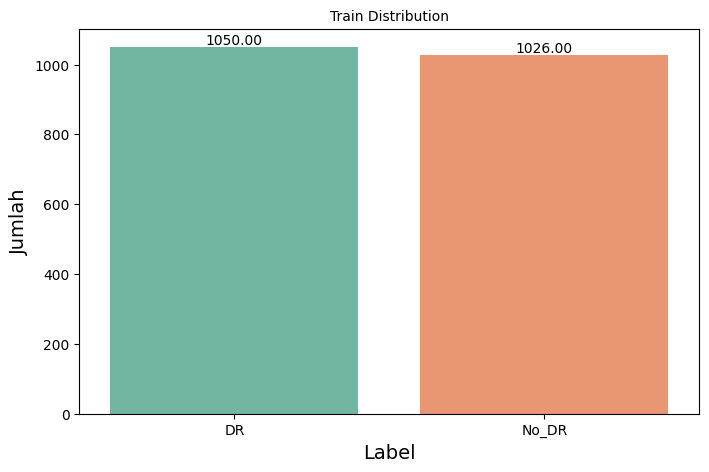

In [18]:
# Menampilkan visualisasi train_df
visualize_data(train_df, 'Train')

Dari visualisasi diatas, distribusi pada data train adalah 1050 untuk DR dan 1026 untuk No_DR.

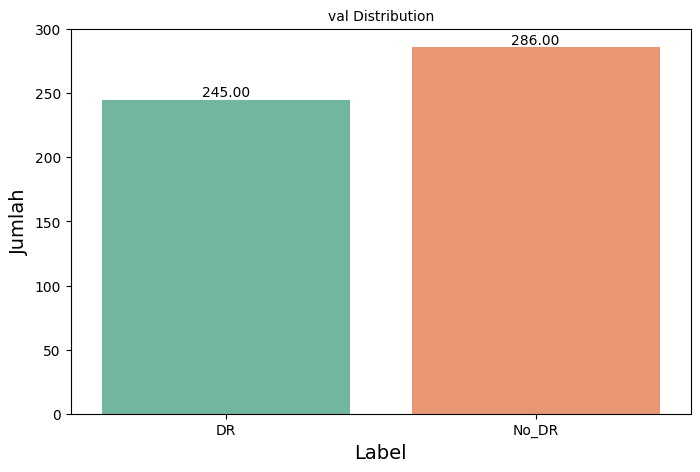

In [19]:
# Menampilkan visualisasi val_df
visualize_data(val_df, 'val')

Dari visualisasi diatas, distribusi pada data validation adalah 245 untuk DR dan 286 untuk No_DR.

## Menampilkan 10 gambar pada train_df (5 gambar dengan label "DR" dan 5 gambar dengan label "No_DR")

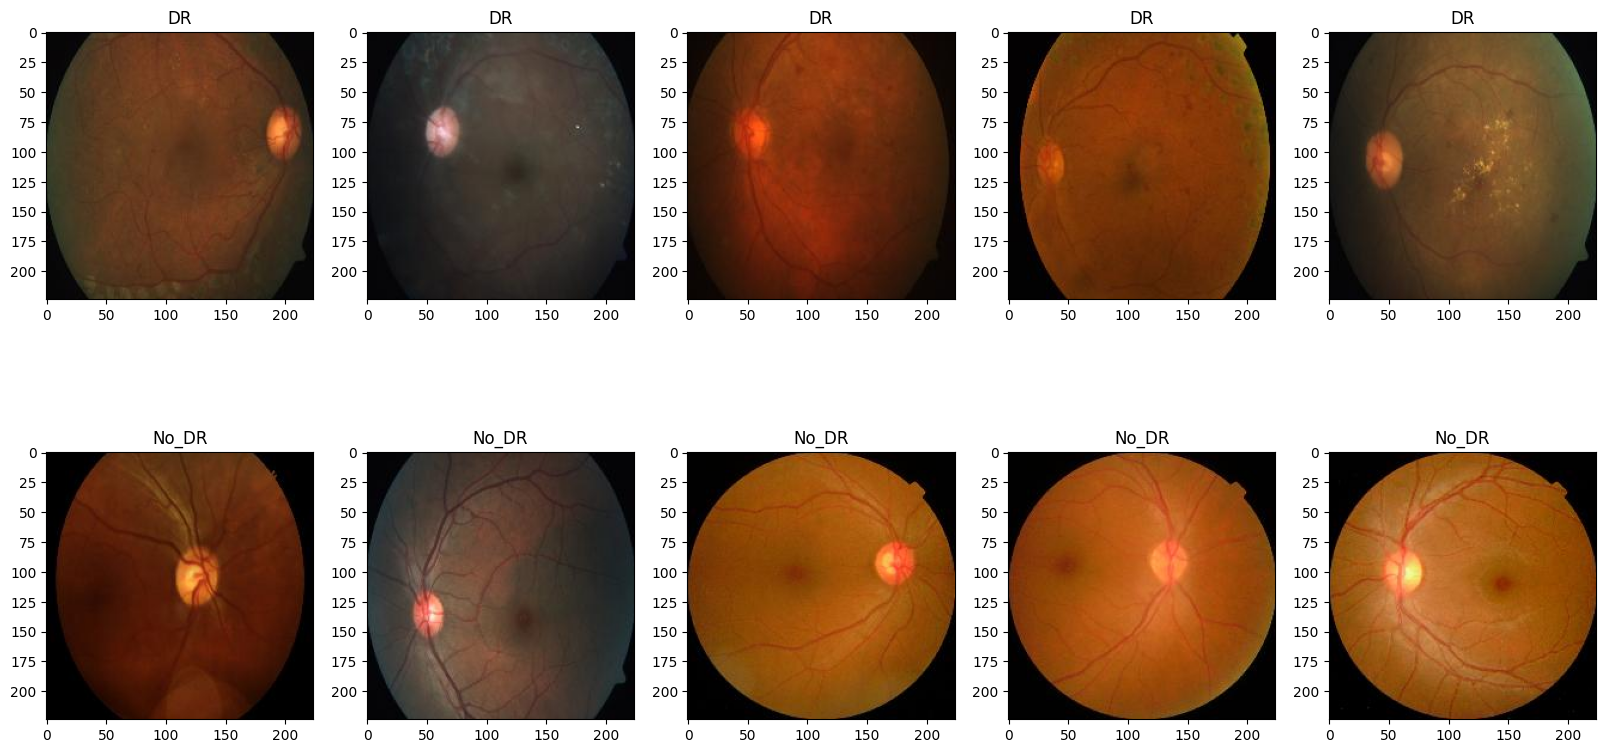

In [20]:
# Get few samples for both the classes
dr_samples = (train_df[train_df['label']=="DR"]['images'].iloc[:5]).tolist()
no_dr_samples = (train_df[train_df['label']=='No_DR']['images'].iloc[:5]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(dr_samples + no_dr_samples)

Visualisasi diatas memperlihatkan perbedaan antara kondisi retina yang sehat dan yang terdampak Diabetic Retinopathy. Pada penderita Diabetic Retinopathy menunjukkan tanda-tanda kerusakan retina seperti pendarahan, bercak, dan perubahan pembuluh darah, sedangkan 5 gambar dibawahnya tampak normal tanpa tanda-tanda tersebut.

# 5. Feature Engineering

AUGMENTASI DATA

In [21]:
# Pengaturan gambar
img_height= 220
img_width= 220
SEED = 1
BATCH =64

Pengaturan diatas dilakukan agar data yang ditampilkan seragam, yaitu tinggi dan lebar gambar menjadi 220 piksel, nilai seed 1, dan menetapkan jumlah data per grup (batch) menjadi 64 untuk pemrosesan gambar.

In [22]:
# Membuat image generator
train_datagen = ImageDataGenerator(
    rescale=1./255, #normalisasi pixel
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Fungsi diatas digunakan untuk mengolah data gambar dengan melakukan normalisasi dan augmentasi untuk meningkatkan variasi data train, serta normalisasi untuk data validasi dan data test.

In [23]:
# dari dataframe bukan directory
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width), #ini buat nentuin target biar sama sizenya
    class_mode='binary',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED)

ds_val = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

ds_test = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

Found 2076 validated image filenames belonging to 2 classes.
Found 531 validated image filenames belonging to 2 classes.
Found 231 validated image filenames belonging to 2 classes.


Dari data diatas dapat diketahui bahwa :
1. Terdapat 2076 images yang termasuk kedalam 2 classes.
2. Terdapat 532 images yang termasuk kedalam 2 classes.
3. Terdapat 231 images yang termasuk kedalam 2 classes.

In [24]:
# Menampilkan label kelas menjadi angka
ds_train.class_indices

{'DR': 0, 'No_DR': 1}

Kelas yang disebutkan sebelumnya adalah : 'DR' yang diidentifikasi menjadi 0, dan 'No_DR' yang diidentifikasi menjadi 1.

# 6. Model Definition and Training (Model Sequential)

## Model Sequential

In [25]:
# Menetapkan dimensi input gambar
inputs = [img_height, img_width, 3]

# Membuat model Sequential
model_base = Sequential()

model_base.add(Conv2D(filters=32, kernel_size=3, activation='relu',
                       input_shape=inputs))
model_base.add(MaxPooling2D(pool_size=2, strides=2)) # MaxPooling: mengurangi dimensi spasial (lebar dan tinggi) dari gambar

model_base.add(Conv2D(filters=32, kernel_size=3, activation='relu',
                       padding='same'))
model_base.add(MaxPooling2D(pool_size=2, strides=2))

model_base.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model_base.add(MaxPooling2D(pool_size=2, strides=2))


model_base.add(Flatten()) # Flatten: Mengubah data yang berbentuk multi-dimensi menjadi satu dimensi
model_base.add(Dense(units=128, activation='relu')) # Menambahkan lapisan Dense dengan 128 neuron
model_base.add(Dense(units=1, activation='sigmoid')) # Menambahkan lapisan Dense lain sebagai lapisan output dengan 1 neuron


In [26]:
# Menampilkan summary model_base
model_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 109, 109, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

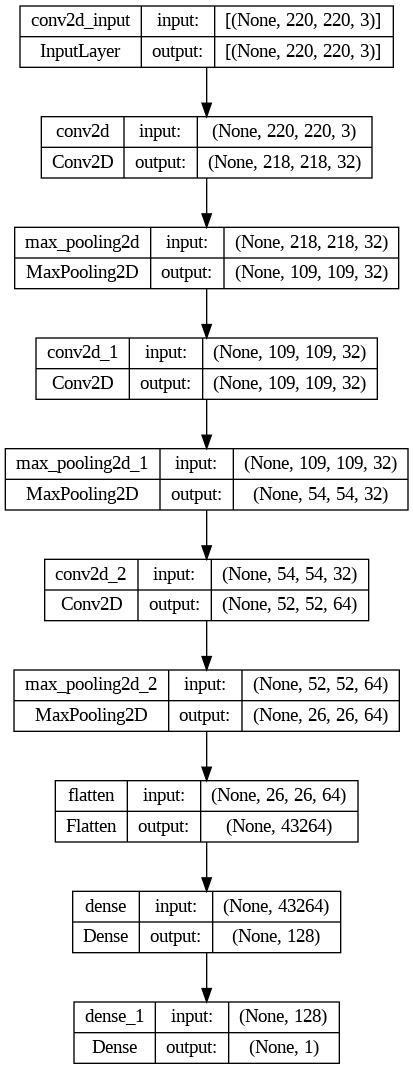

In [27]:
# Menampilkan arsitektur model_base
tf.keras.utils.plot_model(model_base, show_shapes=True)

Penjelasan dari summary dan arsitektur model sequential:

**1. InputLayer:**
Fungsi: Layer ini menerima input gambar dengan ukuran (220, 220, 3), yang berarti gambar tersebut memiliki tinggi 220 piksel, lebar 220 piksel, dan 3 channel warna (RGB).

**2. Conv2D (conv2d):**
Fungsi: Layer konvolusi ini mengaplikasikan 32 filter (atau kernel) pada gambar untuk mengekstrak ciri-ciri atau fitur.

Input: Menerima gambar ukuran (220, 220, 3).
Output: Menghasilkan 32 feature map dengan ukuran (218, 218).

**3.MaxPooling2D (max_pooling2d):**
Fungsi: Mengurangi dimensi dari feature map dengan memilih nilai maksimum dari area tertentu pada feature map (biasanya 2x2).

Input: Menerima 32 feature map ukuran (218, 218).
Output: Menghasilkan 32 feature map yang telah direduksi menjadi ukuran (109, 109).

**4.Conv2D (conv2d_1):**
Fungsinya sama seperti layer Conv2D pertama, tapi beroperasi pada output dari MaxPooling2D sebelumnya.

**5.MaxPooling2D (max_pooling2d_1):**
Fungsinya sama seperti MaxPooling2D pertama.

**6.Conv2D (conv2d_2):**
Layer konvolusi ini menggunakan lebih banyak filter (64) untuk mengekstrak fitur yang lebih kompleks.

Input: Menerima 32 feature map ukuran (54, 54).
Output: Menghasilkan 64 feature map dengan ukuran (52, 52).

**7.MaxPooling2D (max_pooling2d_2):**
Fungsinya sama seperti MaxPooling2D lainnya, mengurangi ukuran feature map menjadi (26, 26).

**8.Flatten (flatten):**
Fungsi: Mengubah feature map dua dimensi menjadi vektor satu dimensi agar dapat diproses oleh layer Dense.

Output: Vektor satu dimensi dengan 43.264 elemen.

**9.Dense (dense):**
Fungsi: Layer yang mengekstrak pola dari vektor fitur dengan menghubungkan setiap input ke setiap neuron di layer ini.

Output: Vektor dengan 128 elemen.

**10.Dense (dense_1):**
Fungsi: Layer akhir yang menghasilkan satu output, yang mungkin merepresentasikan probabilitas atau kelas dari input gambar.

Output: Satu nilai (biasanya untuk tugas klasifikasi biner).

## Model Sequential - Training

In [28]:
callbacks1 = [
    EarlyStopping(monitor='val_loss', patience= 3), # Menghentikan pelatihan secara lebih awal
    ModelCheckpoint('model_sequential.hdf5', monitor='val_loss', save_best_only=True) # Menyimpan model pada kondisi terbaiknya
]

In [29]:
# Mengonfigurasi model_base menggunakan metrics 'precision'
model_base.compile(optimizer='adamax', loss='binary_crossentropy', metrics= tf.keras.metrics.Precision())

In [30]:
# Melatih model_base
history = model_base.fit(ds_train, batch_size= BATCH,
                           epochs= 25, validation_data= ds_val,
                           callbacks= callbacks1)

Epoch 1/25
33/33 [==============================] - 44s 1s/step - loss: 0.5760 - precision: 0.6800 - val_loss: 0.3618 - val_precision: 0.9325
Epoch 2/25
33/33 [==============================] - 30s 920ms/step - loss: 0.3985 - precision: 0.8579 - val_loss: 0.2893 - val_precision: 0.8831
Epoch 3/25
33/33 [==============================] - 32s 976ms/step - loss: 0.3388 - precision: 0.8630 - val_loss: 0.2679 - val_precision: 0.9255
Epoch 4/25
33/33 [==============================] - 30s 902ms/step - loss: 0.2965 - precision: 0.8859 - val_loss: 0.3334 - val_precision: 0.8613
Epoch 5/25
33/33 [==============================] - 28s 850ms/step - loss: 0.2616 - precision: 0.9109 - val_loss: 0.2347 - val_precision: 0.8868
Epoch 6/25
33/33 [==============================] - 30s 891ms/step - loss: 0.2480 - precision: 0.9119 - val_loss: 0.2405 - val_precision: 0.9030
Epoch 7/25
33/33 [==============================] - 28s 840ms/step - loss: 0.2353 - precision: 0.9172 - val_loss: 0.3055 - val_precis

Dari hasil di atas, model mengalami peningkatan nilai precision dan penurunan nilai loss baik pada data train maupun pada data validation.

# 7. Model Definition and Training (Model Functional)

##  Model Functional

In [31]:
# Clear session and set random seed
tf.keras.backend.clear_session()
seed = 42
tf.random.set_seed(seed)

# Define the input shape
input_shape = (220, 220, 3)

# Define Input layer
input_layer = Input(shape=input_shape, name='input_layer')

# Dense layers on the input directly, this is unusual and typically not done in practice
# for image data, as Convolutional layers are more common. This is just for the example.
dense_layer1 = Dense(10, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed))(input_layer)
dense_layer1_output = Dense(10, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed))(dense_layer1)

dense_layer2 = Dense(10, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed))(input_layer)
dense_layer2_output = Dense(10, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(seed))(dense_layer2)

# Flatten the output of the dense layers
flatten_layer1 = Flatten()(dense_layer1_output)
flatten_layer2 = Flatten()(dense_layer2_output)

# Concatenate the flattened outputs
concatenated = concatenate([flatten_layer1, flatten_layer2])

# Output layer for binary classification
output_layer = Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.GlorotNormal(seed))(concatenated)

# Create Functional model
model_functional = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_functional.compile(optimizer='adamax', loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision()])

# Display the model summary to verify the output shape is correct
model_functional.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 220, 220, 3)]        0         []                            
                                                                                                  
 dense (Dense)               (None, 220, 220, 10)         40        ['input_layer[0][0]']         
                                                                                                  
 dense_2 (Dense)             (None, 220, 220, 10)         40        ['input_layer[0][0]']         
                                                                                                  
 dense_1 (Dense)             (None, 220, 220, 10)         110       ['dense[0][0]']               
                                                                                              

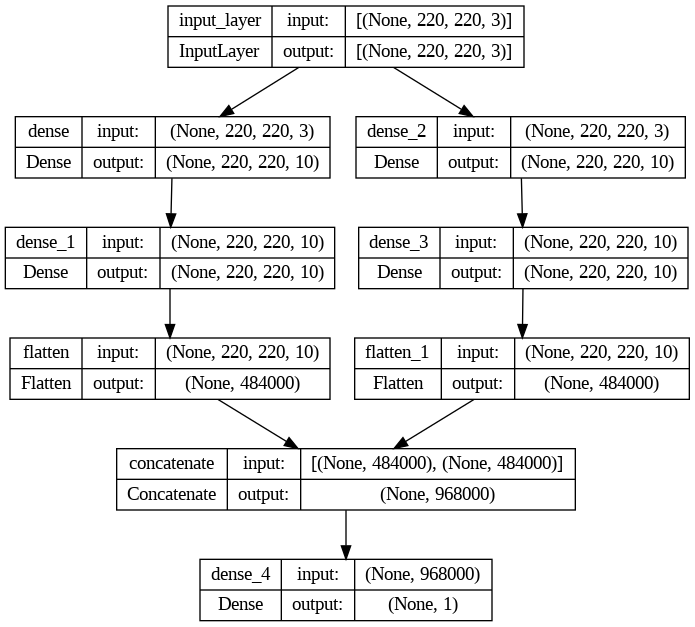

In [32]:
# Menampilkan arsitektur model_functional
tf.keras.utils.plot_model(model_functional, show_shapes=True)

Penjelasan dari summary dan arsitektur model functional:

1. **InputLayer:**
   - Fungsi: Menerima input gambar dengan ukuran 220x220 piksel dengan 3 channel (RGB).
   - Output Shape: (None, 220, 220, 3), di mana "None" mewakili ukuran batch yang tidak ditentukan.

2. **Dense dan Dense_2:**
   - Fungsi: Lapisan ini terhubung penuh dengan setiap elemen piksel pada gambar. Masing-masing piksel direpresentasikan sebagai vektor dengan 10 elemen setelah lapisan ini.
   - Output Shape: (None, 220, 220, 10), di mana setiap piksel kini memiliki 10 fitur.

3. **Dense_1 dan Dense_3:**
   - Fungsi: Lapisan kedua Dense yang juga terhubung penuh, mengambil output dari lapisan Dense sebelumnya.
   - Output Shape: Sama seperti lapisan Dense sebelumnya, yaitu (None, 220, 220, 10).

4. **Flatten dan Flatten_1:**
   - Fungsi: Mengubah data 3D dari output lapisan Dense menjadi vektor 1D.
   - Output Shape: (None, 484000), di mana setiap gambar kini direpresentasikan sebagai vektor panjang tunggal.

5. **Concatenate:**
   - Fungsi: Menggabungkan dua vektor panjang dari kedua lapisan Flatten menjadi satu vektor yang lebih panjang.
   - Output Shape: (None, 968000), menggabungkan kedua vektor 484000 elemen menjadi satu vektor 968000 elemen.

6. **Dense_4:**
   - Fungsi: Lapisan output yang melakukan klasifikasi biner, mengambil vektor panjang dan menghasilkan satu nilai skalar, yang biasanya diinterpretasikan sebagai probabilitas dari kelas positif.
   - Output Shape: (None, 1), di mana setiap sampel menghasilkan satu nilai output.

## Model Functional - Training

In [33]:
callbacks2 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('model_functional.keras', save_best_only=True)
]

In [34]:
# Mengonfigurasi model Xception yang telah dibuat sebelumnya
model_functional.compile(optimizer='adamax', loss='binary_crossentropy', metrics= tf.keras.metrics.Precision())

In [35]:
# Melatih model_base
history_functional = model_functional.fit(ds_train, batch_size= BATCH,
                           epochs= 25, validation_data= ds_val,
                           callbacks= callbacks1)

Epoch 1/25
33/33 [==============================] - 32s 909ms/step - loss: 9.7942 - precision_1: 0.5754 - val_loss: 1.2359 - val_precision_1: 0.8911
Epoch 2/25
33/33 [==============================] - 30s 912ms/step - loss: 1.6432 - precision_1: 0.7578 - val_loss: 1.3277 - val_precision_1: 0.9500
Epoch 3/25
33/33 [==============================] - 30s 912ms/step - loss: 1.3432 - precision_1: 0.7763 - val_loss: 0.9079 - val_precision_1: 0.7618
Epoch 4/25
33/33 [==============================] - 30s 911ms/step - loss: 0.8232 - precision_1: 0.7733 - val_loss: 0.6293 - val_precision_1: 0.7768
Epoch 5/25
33/33 [==============================] - 30s 902ms/step - loss: 0.5730 - precision_1: 0.8031 - val_loss: 0.3522 - val_precision_1: 0.8829
Epoch 6/25
33/33 [==============================] - 30s 902ms/step - loss: 0.4250 - precision_1: 0.8467 - val_loss: 0.4065 - val_precision_1: 0.8664
Epoch 7/25
33/33 [==============================] - 29s 868ms/step - loss: 0.3840 - precision_1: 0.8531 - 

Dari hasil di atas, model mengalami peningkatan nilai precision dan fluktuasi nilai loss baik pada data train maupun pada data validation.

# 8. Model Definition and Training (Model Xception)

##  Model Xception

Model Xception menjadi pilihan yang baik karena:

- Xception merupakan model yang telah dilatih sebelumnya pada dataset ImageNet yang sangat besar dan beragam, memberikannya kemampuan untuk mengenali berbagai fitur visual yang mungkin berguna untuk membedakan DR dan No_DR.

- Xception menggunakan depthwise separable convolutions yang efisien dalam menangkap fitur dengan jumlah parameter yang lebih sedikit dibandingkan dengan konvolusi tradisional, membuatnya lebih cepat dalam inferensi tanpa mengorbankan performa.

- Model ini terkenal dengan performa tinggi dalam banyak tugas pengenalan gambar.

In [36]:
# Buat model Xception tanpa lapisan output terakhir
model_3 = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Membekukan lapisan-lapisan di Xception agar tidak dapat dilatih lagi
for layer in model_3.layers:
    layer.trainable = False

# Membuat model baru dengan menambahkan Xception dan lapisan acak
modelXception = Sequential([
    model_3,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [37]:
# Menampilkan summary modelXception
modelXception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_5 (Dense)             (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 513       
                                                                 
Total params: 21911081 (83.58 MB)
Trainable params: 1049601 (4.00 MB)
Non-trainable params: 20861480 (79.58 MB)
__________

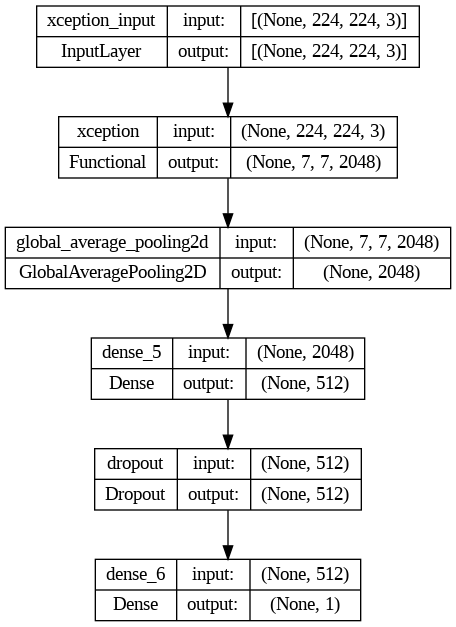

In [38]:
# Menampilkan arsitektur
tf.keras.utils.plot_model(modelXception, show_shapes=True)

Penjelasan dari summary dan arsitektur model xception:

1. **InputLayer:**
   - Fungsi: layer pertama yang menerima gambar masukan.
   - Output Shape: (None, 224, 224, 3). Ukuran masukan adalah gambar dengan tinggi 224 piksel, lebar 224 piksel, dan 3 channel warna (RGB).

2. **Xception (Functional):**
   - Fungsi: mengambil gambar dan menghasilkan representasi ciri yang lebih abstrak dan informatif.
   - Output Shape: (None, 7, 7, 2048). Setelah gambar melewati Xception, ia dikurangi menjadi peta ciri 7x7 dengan 2048 channel.

3. **GlobalAveragePooling2D:**
   - Fungsi: menghitung rata-rata untuk setiap peta ciri 2048, menghasilkan satu nilai per ciri. Hal ini mengurangi jumlah total data sambil mempertahankan informasi penting.
   - Output Shape: (None, 2048). Dari setiap peta ciri 7x7, kini kita mendapatkan satu vektor 2048 elemen.

4. **Dense (dense_2):**
   - Fungsi: layer neuron yang terhubung penuh yang berfungsi untuk mempelajari kombinasi non-linear dari fitur yang diberikan oleh GlobalAveragePooling2D.
   - Output Shape: (None, 512). Menghasilkan vektor fitur dengan 512 elemen.

5. **Dropout:**
   - Fungsi: secara acak "mematikan" sebagian neuron selama pelatihan, yang membantu mencegah overfitting.
   - Output Shape: (None, 512). Ukuran output tidak berubah; dropout tidak mengubah dimensi, hanya mengatur beberapa nilai menjadi nol secara acak.

6. **Dense (dense_3):**
   - Fungsi: layer output yang menghasilkan prediksi akhir. Dalam kasus ini, sepertinya untuk tugas klasifikasi biner (mengingat hanya ada satu neuron output).
   - Output Shape: (None, 1). Setiap sampel menghasilkan satu nilai skalar, yang bisa diinterpretasikan sebagai probabilitas kelas target.

## Model Xception - Training

In [39]:
# Pra-pemrosesan gambar dan augmentasi data
train_datagen_xception = ImageDataGenerator(
    rescale=1./255, #normalisasi pixel
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen_xception = ImageDataGenerator(rescale=1./255)
test_datagen_xception = ImageDataGenerator(rescale=1./255)

In [40]:
# Generator untuk data train
train_generator = train_datagen_xception.flow_from_directory(
    directory = '/content/images/train',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=64,
    shuffle=True,
    seed=1  # Untuk reproducibility
)

# Generator untuk data validasi
validation_generator = val_datagen_xception.flow_from_directory(
    directory = '/content/images/valid',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=64,
    shuffle=False,
    seed=1  # Untuk reproducibility
)

# Generator untuk data test
test_generator = test_datagen_xception.flow_from_directory(
    directory = '/content/images/test',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=64,
    shuffle=False
)

Found 2076 images belonging to 2 classes.
Found 531 images belonging to 2 classes.
Found 231 images belonging to 2 classes.


Setelah dilakukan augmentasi data, dari data diatas dapat diketahui bahwa :
1. Terdapat 2076 images yang termasuk kedalam 2 classes.
2. Terdapat 532 images yang termasuk kedalam 2 classes.
3. Terdapat 231 images yang termasuk kedalam 2 classes.

In [41]:
# callback3
callbacks3 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('model_xception.h5', monitor='val_loss', save_best_only=True)
]

In [42]:
# Mengonfigurasi model Xception yang telah dibuat sebelumnya
modelXception.compile(optimizer='adamax', loss='binary_crossentropy', metrics= tf.keras.metrics.Precision())

In [43]:
# Pelatihan model menggunakan generator yang telah didefinisikan sebelumnya
history_xception = modelXception.fit(train_generator, batch_size= BATCH,
                           epochs= 25, validation_data= validation_generator,
                           callbacks= callbacks3)

Epoch 1/25
33/33 [==============================] - 48s 1s/step - loss: 0.3372 - precision_2: 0.8602 - val_loss: 0.3425 - val_precision_2: 0.7899
Epoch 2/25
33/33 [==============================] - 36s 1s/step - loss: 0.2204 - precision_2: 0.9001 - val_loss: 0.3027 - val_precision_2: 0.8034
Epoch 3/25
33/33 [==============================] - 34s 1s/step - loss: 0.2019 - precision_2: 0.9242 - val_loss: 0.3897 - val_precision_2: 0.7371
Epoch 4/25
33/33 [==============================] - 33s 1s/step - loss: 0.1966 - precision_2: 0.9175 - val_loss: 0.2990 - val_precision_2: 0.7901
Epoch 5/25
33/33 [==============================] - 34s 1s/step - loss: 0.1778 - precision_2: 0.9305 - val_loss: 0.1999 - val_precision_2: 0.9006
Epoch 6/25
33/33 [==============================] - 33s 1s/step - loss: 0.1886 - precision_2: 0.9341 - val_loss: 0.2114 - val_precision_2: 0.8685
Epoch 7/25
33/33 [==============================] - 33s 990ms/step - loss: 0.1713 - precision_2: 0.9272 - val_loss: 0.2536 -

Dari hasil model training di atas, dapat disimpulkan bahwa model tersebut secara umum menjadi lebih akurat dalam memprediksi kasus positif (precision meningkat) seiring dengan berjalannya pelatihan meskipun terdapat fluktuasi dalam nilai loss dan nilai precision.

# 9. Model Evaluation

## 9.1 Model Sequential

In [44]:
test_results = model_base.evaluate(ds_test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Precision : {test_results[1]:.4f}')

Test Loss     : 0.2023
Test Precision : 0.9268


Dari hasil evaluasi model pada test set, dapat disimpulkan bahwa model memiliki nilai loss 0.2021 yang menunjukkan bahwa rata-rata error atau kesalahan prediksi relatif rendah, dan nilai precision 0.9268 yang menunjukkan model mampu memprediksi kelas yang benar sekitar 92%.

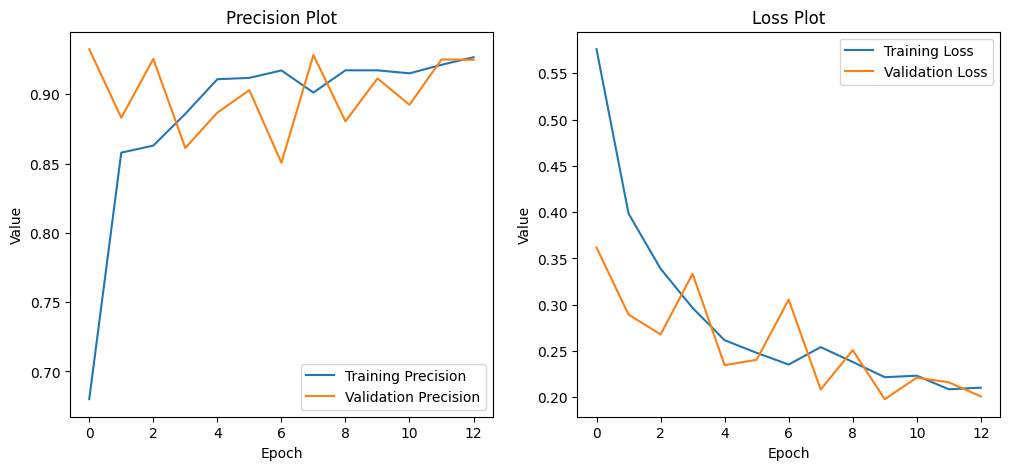

In [45]:
# Membuat figure
plt.figure(figsize=(12, 5))

# Plot Precision
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")

# Menampilkan visualisasi
plt.show()


- **Precision Plot:**
  - **Training Precision:** Model cukup akurat dalam memprediksi data train dan nilai precision meningkat di awal lalu stabil di 90%.
  - **Validation Precision:** Model akurat pada data validasi, dengan nilai precision yang sedikit berfluktuasi tetapi secara umum sejajar dengan training precision.

- **Loss Plot:**
  - **Training Loss:** Nilai training loss menurun dengan tajam pada awalnya, kemudian penurunan menjadi lebih lambat dan stabil.
  - **Validation Loss:** Nilai validation loss mengikuti tren yang serupa dengan training loss, turun tajam dan kemudian stabil.

Kesimpulan dari kedua plot ini adalah bahwa model bekerja dengan baik dan menunjukkan kemampuan yang baik dalam memprediksi pada data train maupun data baru. Tidak ada tanda-tanda overfitting karena nilai yang dihasilkan cukup serupa dan stabil.

### Classification Report

In [46]:
test_pred = model_base.predict(ds_test)
y_pred_test = np.where(test_pred>=0.6,1,0)

announce = classification_report(ds_test.labels,
                                    y_pred_test, labels = np.arange(33),
                                    target_names= list(ds_test.class_indices.keys()))
print(announce)

4/4 [==============================] - 1s 109ms/step
              precision    recall  f1-score   support

          DR       0.91      0.94      0.93       113
       No_DR       0.94      0.92      0.93       118

   micro avg       0.93      0.93      0.93       231
   macro avg       0.06      0.06      0.06       231
weighted avg       0.93      0.93      0.93       231



Dari classification report diatas, dapat disimpulkan bahwa:

- **Nilai Precision untuk DR (0.91)**: Hampir semua pasien yang model prediksi sebagai DR memang benar memiliki DR, dengan hanya sedikit kesalahan.
- **Nilai Precision untuk No_DR (0.94)**: Mayoritas pasien yang model prediksi tidak memiliki DR memang benar tidak memilikinya, tapi ada beberapa pasien yang salah diklasifikasikan.

Secara umum, model cukup baik dalam menentukan status DR berdasarkan data yang diberikan, dengan tingkat keakuratan yang tinggi.

### Confussion Matrix

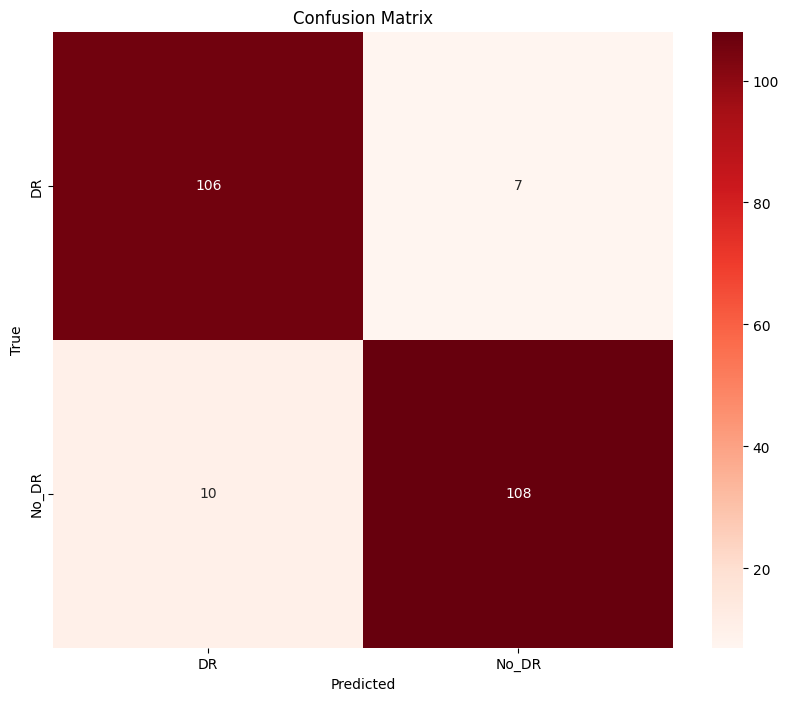

In [47]:
y_true = ds_test.labels
# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_test )

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=list(ds_test.class_indices.keys()), yticklabels=list(ds_test.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Dari confusion matrix di atas, dapat disimpulkan bahwa:

- **True Positives (TP): 106** - Model ini berhasil memprediksi keberadaan Diabetic Retinopathy (DR) sebanyak 106 kali dengan benar, yang berarti bahwa 106 pasien yang memang memiliki DR diidentifikasi tepat oleh model.
  
- **False Negatives (FN): 7** - Ada 7 pasien yang sesungguhnya menderita DR tetapi model gagal mengenalinya dan salah mengklasifikasikan mereka sebagai tidak menderita DR, menunjukkan bahwa model masih melewatkan beberapa kasus positif.

- **True Negatives (TN): 108** - Model ini juga berhasil mengidentifikasi tidak adanya DR pada 108 pasien, yang artinya 108 pasien yang tidak menderita DR diklasifikasikan dengan benar oleh model.

- **False Positives (FP): 10** - Model salah memprediksi bahwa 10 pasien menderita DR padahal sebenarnya mereka tidak, yang menunjukkan bahwa ada beberapa kekeliruan dalam mengklasifikasikan kondisi sehat sebagai DR.

Model ini menunjukkan kinerja yang cukup baik dalam mengidentifikasi kedua kondisi (baik DR maupun tidak ada DR), dengan jumlah kesalahan yang relatif rendah baik untuk false positives maupun false negatives, yang menandakan tingkat keseimbangan yang baik antara sensitivitas dan spesifisitas.

## 9.2 Model Functional

In [48]:
test_results = model_functional.evaluate(ds_test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Precision : {test_results[1]:.4f}')

Test Loss     : 0.7704
Test Precision : 0.6444


Dari hasil evaluasi model pada test set, dapat disimpulkan bahwa model memiliki nilai loss 0.7704 yang menunjukkan bahwa rata-rata error atau kesalahan prediksi relatif tinggi, dan nilai precision sebesar 0.6444 yang menunjukkan model kurang mampu memprediksi kelas yang benar hanya sekitar 64%.

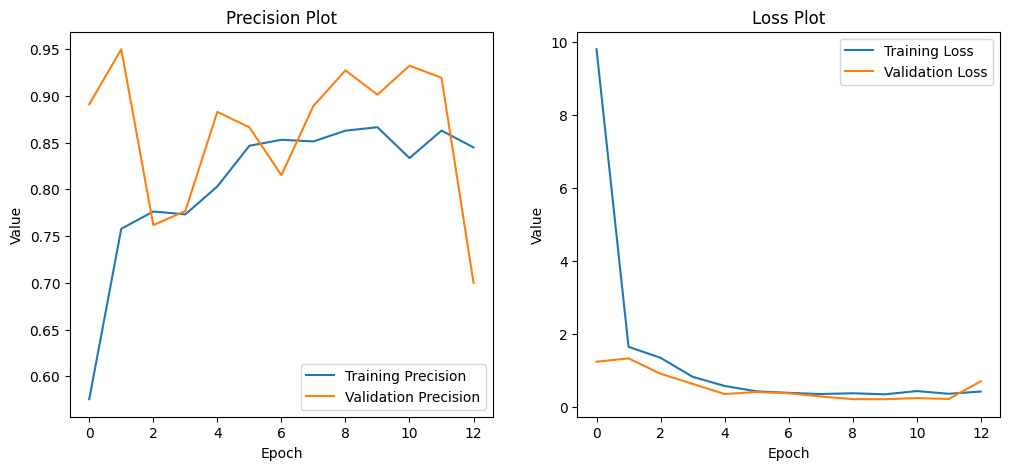

In [49]:
# Membuat figure
plt.figure(figsize=(12, 5))

# Plot Precision
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(history_functional.history['precision_1'], label='Training Precision')
plt.plot(history_functional.history['val_precision_1'], label='Validation Precision')
plt.title('Precision Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(history_functional.history['loss'], label='Training Loss')
plt.plot(history_functional.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")

# Menampilkan visualisasi
plt.show()


- **Precision Plot:**
  - **Training Precision:** Model menunjukkan peningkatan pembelajaran pada data training.
  - **Validation Precision:** Fluktuasi pada validation precision mengindikasikan ketidakstabilan dalam kinerja model pada data validasi dari satu epoch ke epoch lainnya

- **Loss Plot**
  - **Training Loss:** Nilai training dimulai sangat tinggi tetapi menurun tajam dan stabil mendekati nol, menunjukkan bahwa model semakin baik dalam memprediksi data training.
  - **Validation Loss:** Nilai validation menurun tajam pada awalnya tetapi kemudian berfluktuasi, menunjukkan bahwa model tersebut mungkin mengalami kesulitan untuk konsisten pada data validasi.

Kesimpulannya, model ini bekerja dengan baik pada data train namun menunjukkan kurangnya konsistensi dalam performa pada data validation.

### Classification Report

In [50]:
test_pred_func = model_functional.predict(ds_test)
y_pred_test_func = np.where(test_pred_func>=0.6,1,0)

announceFunction = classification_report(ds_test.labels,
                                    y_pred_test_func, labels = np.arange(33),
                                    target_names= list(ds_test.class_indices.keys()))
print(announceFunction)

4/4 [==============================] - 1s 115ms/step
              precision    recall  f1-score   support

          DR       0.96      0.64      0.77       113
       No_DR       0.74      0.97      0.84       118

   micro avg       0.81      0.81      0.81       231
   macro avg       0.05      0.05      0.05       231
weighted avg       0.85      0.81      0.80       231



Dari classification report diatas, dapat disimpulkan bahwa:

- **Nilai Precision untuk DR (0.96)**: Hampir semua pasien yang model prediksi sebagai DR memang benar memiliki DR, dengan hanya sedikit kesalahan.
- **Nilai Precision untuk No_DR (0.74)**: Mayoritas pasien yang model prediksi tidak memiliki DR memang benar tidak memilikinya, tapi ada beberapa pasien yang salah diklasifikasikan.

Secara umum, model cukup baik dalam menentukan status DR berdasarkan data yang diberikan.

### Confussion Matrix

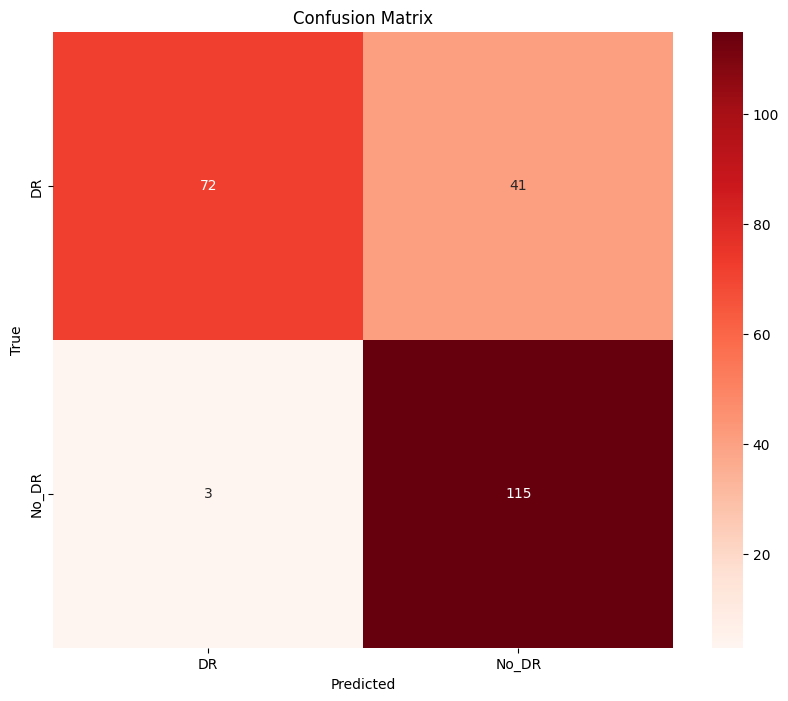

In [51]:
y_true_func = ds_test.labels
# Calculate the confusion matrix
cm_func = confusion_matrix(y_true_func, y_pred_test_func)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_func, annot=True, fmt='d', cmap='Reds', xticklabels=list(ds_test.class_indices.keys()), yticklabels=list(ds_test.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Dari confusion matrix di atas, dapat disimpulkan bahwa:

- **True Positives (TP): 72** - Model telah berhasil memprediksi Diabetic Retinopathy (DR) sebanyak 72 kali, yang berarti 72 pasien yang sebenarnya memiliki DR telah diidentifikasi dengan benar oleh model sebagai memiliki DR.
  
- **False Negatives (FN): 41** - Sebanyak 41 pasien yang sebenarnya memiliki DR tidak terdeteksi oleh model dan keliru diprediksi sebagai tidak memiliki DR, ini menunjukkan kekurangan model dalam mengidentifikasi semua kasus positif.

- **True Negatives (TN): 115** - Model telah berhasil memprediksi tidak adanya DR sebanyak 115 kali, yang berarti 115 pasien yang sebenarnya tidak memiliki DR telah diidentifikasi dengan benar oleh model sebagai tidak memiliki DR.

- **False Positives (FP): 3** - Hanya 3 pasien yang sebenarnya tidak memiliki DR keliru diprediksi oleh model sebagai memiliki DR, ini menunjukkan bahwa model sangat baik dalam tidak mengklasifikasikan secara keliru kasus yang sehat sebagai DR.

Kesimpulan umum yang bisa diambil adalah model ini memiliki spesifisitas yang tinggi (tingkat keberhasilan tinggi dalam memprediksi kasus negatif) tetapi sensitivitasnya kurang (beberapa kasus positif terlewat). Ini bisa menjadi perhatian, terutama dalam konteks medis di mana mengidentifikasi kondisi yang sebenarnya ada (DR dalam hal ini) sangat penting.

## 9.3 Model Xception

In [52]:
test_results = modelXception.evaluate(ds_test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Precision : {test_results[1]:.4f}')

Test Loss     : 0.1618
Test Precision : 0.9134


Dari hasil evaluasi di atas, model Xception memperlihatkan kinerja yang cukup baik pada data tes dengan nilai loss yang rendah (0.1437) dan nilai precision yang tinggi (0.9268).

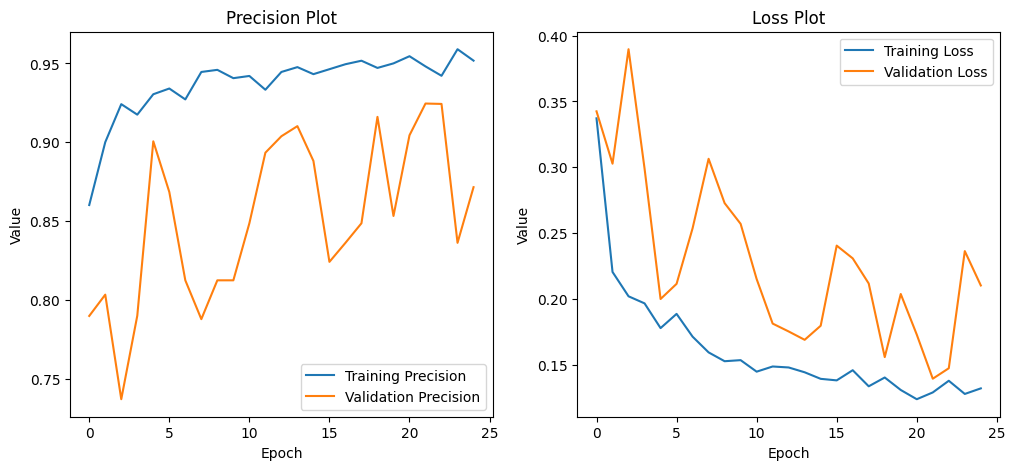

In [53]:
# Membuat figure 2 plot
plt.figure(figsize=(12, 5))

# Plot Precision
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(history_xception.history['precision_2'], label='Training Precision')
plt.plot(history_xception.history['val_precision_2'], label='Validation Precision')
plt.title('Precision Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot Loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(history_xception.history['loss'], label='Training Loss')
plt.plot(history_xception.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")

# Menampilkan visualisasi
plt.show()


- **Precision Plot:**
  - **Training Precision:** Model cukup stabil dan tinggi sepanjang epoch, berfluktuasi sedikit di atas 0.90, yang menunjukkan bahwa model secara konsisten benar dalam memprediksi data pelatihan.
  - **Validation Precision:** Model mengalami fluktuasi yang signifikan, dengan nilai terendah sekitar 0.80 dan tertinggi mendekati 0.95, yang menandakan model tersebut memiliki kinerja yang berubah-ubah pada data validasi.

- **Loss Plot**
  - **Training Loss:** Nilai training menurun dari awal dan berfluktuasi antara 0.15 dan 0.25, menunjukkan model tersebut berubah dalam memperkirakan data training dengan akurasi yang meningkat.

  - **Validation Loss:** Nilai validation loss memiliki variasi yang lebih besar dibandingkan dengan training loss. Terdapat ketidakstabilan dalam model ketika diuji pada data validasi dan mungkin menunjukkan bahwa model kurang baik dalam menggeneralisasi data.

Kesimpulannya, meskipun model tersebut terlatih dengan baik pada data training (seperti yang ditunjukkan oleh training precision yang tinggi), kinerjanya pada data validasi tidak konsisten yang dapat dilihat dari fluktuasi yang signifikan dalam validation precision dan validation loss. Ini mungkin menandakan bahwa model tersebut perlu disesuaikan lebih lanjut untuk mengurangi overfitting dan meningkatkan kemampuannya dalam menggeneralisasi ke data baru.

### Classification Report

In [54]:
test_predXception = modelXception.predict(test_generator)
y_pred_testXception = np.where(test_predXception>=0.6,1,0)

announceXception = classification_report(test_generator.labels,
                                    y_pred_testXception, labels = np.arange(25),
                                    target_names= list(test_generator.class_indices.keys()))
print(announceXception)

4/4 [==============================] - 5s 1s/step
              precision    recall  f1-score   support

          DR       0.98      0.91      0.94       113
       No_DR       0.92      0.98      0.95       118

   micro avg       0.95      0.95      0.95       231
   macro avg       0.08      0.08      0.08       231
weighted avg       0.95      0.95      0.95       231



Dari classification report diatas, dapat disimpulkan bahwa:

- **Nilai Precision untuk DR (0.98)**: Jika model menyatakan bahwa seseorang memiliki Diabetic Retinopathy (DR), ada kemungkinan 98% prediksinya benar, menandakan bahwa keakuratan prediksi yang sangat tinggi.
- **Nilai Precision untuk No_DR (0.92)**: Jika model menyatakan bahwa seseorang tidak memiliki DR (No_DR), ada kemungkinan 92% prediksinya benar, menandakan bahwa model juga cukup akurat dalam mengidentifikasi kasus tanpa DR.

Kesimpulannya, model sangat baik dalam memprediksi kasus DR maupun No_DR dengan nilai precision yang tinggi.

### Confussion Matrix

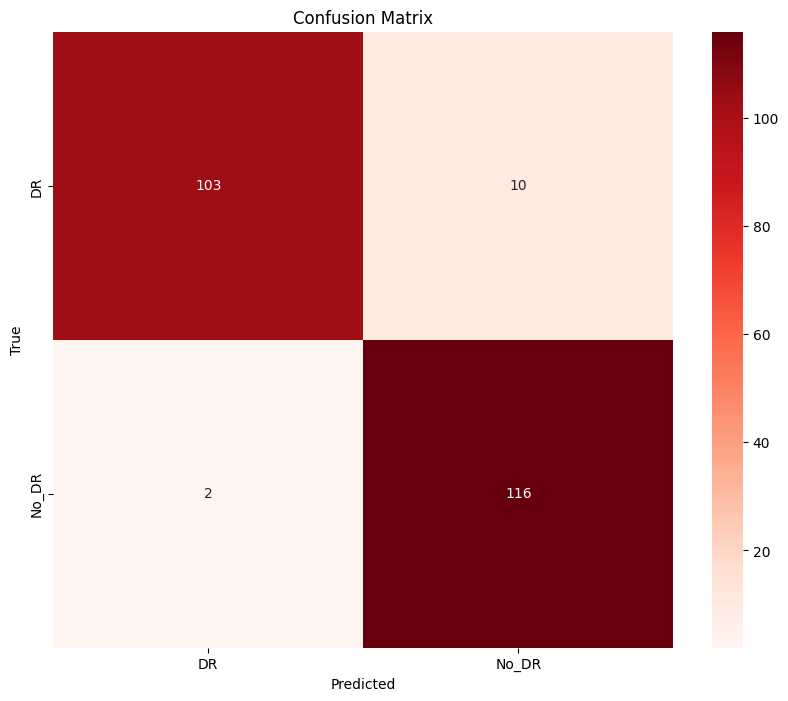

In [55]:
y_trueXception = test_generator.labels
# Calculate the confusion matrix
cmXception = confusion_matrix(y_trueXception, y_pred_testXception )

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cmXception, annot=True, fmt='d', cmap='Reds', xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Dari confusion matrix di atas, dapat disimpulkan bahwa:

- **True Positives (TP): 103** - Model berhasil mengidentifikasi 103 kasus Diabetic Retinopathy (DR) dengan benar, yang artinya pasien-pasien ini secara akurat dideteksi sebagai menderita DR.

- **False Negatives (FN): 10** - Terdapat 10 kasus di mana pasien sebenarnya menderita DR, tetapi model salah mengklasifikasikannya sebagai tidak menderita DR, menunjukkan bahwa model ini melewatkan beberapa kasus DR yang sebenarnya.

- **True Negatives (TN): 116** - Model juga berhasil mengidentifikasi 116 kasus di mana pasien tidak menderita DR dengan benar, ini berarti pasien-pasien ini dikonfirmasi tidak memiliki kondisi DR sesuai dengan kenyataan.

- **False Positives (FP): 2** - Hanya terdapat 2 kasus di mana pasien yang tidak menderita DR diklasifikasikan keliru oleh model sebagai menderita DR, menunjukkan tingkat kesalahan yang sangat rendah untuk diagnosis positif palsu.

Kesimpulan keseluruhan adalah bahwa model ini cukup akurat dalam mengidentifikasi kasus DR dan juga sangat baik dalam memastikan pasien yang tidak menderita DR tidak salah diklasifikasikan sebagai menderita DR, dengan tingkat false positives yang sangat rendah. Ini mengindikasikan bahwa model ini memiliki spesifisitas yang tinggi dan sensitivitas yang cukup baik.

# 10. Model Saving

Model Sequential dipilih menjadi model terbaik, disimpan dengan nama "model_sequential.hdf5"

# 11. Model Inference

Model inference dikerjakan pada notebook P2G7_maulidya_fauziyyah_inference

# 12. Conclusion

1. **Dataset:**
- Dataset "Diagnosis of Diabetic Retinopathy" terbagi menjadi 3 set data yaitu 'train', 'valid', dan 'test'.
- Masing-masing set data 'train', 'valid', dan 'test' memiliki 2 kelas yaitu kelas 'DR' dan 'No_DR'. Selanjutnya kelas 'DR' (Diabetic Retinopathy) diganti menjadi kelas 0 dan 'No_DR' (Tidak Diabetic Retinopathy) menjadi kelas 1.

2. **Data Preprocessing:**
- Setelah dilakukan augmentasi data, didapatkan kesimpulan pada data test terdapat 2076 images yang termasuk kedalam 2 kelas, kemudian pada data validasi terdapat 532 images yang termasuk kedalam 2 kelas, dan pada data test terdapat 231 images yang termasuk kedalam 2 kelas.

3. **Modeling:**
- Ada 3 model yang dilakukan training dan evaluasi, yaitu model Sequential, model Functional, dan model Xception.

4. **Evaluasi Model:**

- Hasil evaluasi model pada model sequential menghasilkan test loss sebesar 0.2023 dan test precision sebesar 0.9268. Pada model functional menghasilkan test loss sebesar 0.7704 dan test precision sebesar 0.6444. Pada model xception menghasilkan test loss sebesar 0.1618 dan test precision sebesar 0.9134.

- Nilai precision pada classification report model sequential pada kelas DR adalah 91% dan pada kelas No_DR adalah 94%. Nilai precision pada classification report model functional pada kelas DR adalah 96% dan pada kelas No_DR adalah 74%. Dan nilai precision pada classification report model xception pada kelas DR adalah 98% dan pada kelas No_DR adalah 92%.
   
- Dari hasil evaluasi dipilih model sequential karena model tersebut mempertahankan nilai precision yang tinggi, artinya model menunjukkan kinerja yang baik. Model sequential juga memiliki keseimbangan antara True Positive dan True Negative, dengan hasil False Negative dan False Positive paling sedikit, yang sangat penting untuk prediksi medis seperti deteksi Retinopati Diabetik (DR). Model ini tampaknya menggeneralisasi data dengan baik, sebagaimana ditunjukkan oleh konvergensi training loss dan validation loss yang menunjukkan sedikit bukti overfitting atau underfitting dibandingkan dengan model lainnya.


**Insight Business:**

- Pemilihan Model Sequential sebagai model terbaik berdasarkan evaluasi teknis menunjukkan potensi yang baik untuk implementasi dalam praktik klinis, khususnya dalam mendeteksi Diabetic Retinopathy (DR). Namun, ada beberapa langkah penting yang perlu diambil sebelum model ini dapat digunakan secara luas:

- Model perlu diuji pada kumpulan data yang lebih besar dan lebih beragam yang belum pernah dilihat sebelumnya untuk memverifikasi kinerjanya dalam kondisi dunia nyata.

- Kinerja model harus dipantau secara berkelanjutan untuk mengidentifikasi bagian analisis yang memerlukan perbaikan dan untuk menyesuaikan model dengan data baru dan praktik klinis yang berkembang.